# Development: De-congestion for PIBT upon tunnel entrance

In [14]:
import sys
sys.path.append('../')

sys.path.append('../../')
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
from panav.environment.env import MultiTunnelEnv,DefaultEmtpyEnv
from panav.hybrid import HybridGraph

from panav.viz import draw_env

import shapely

from panav.ORCA import Ordered_Agent

%load_ext autoreload
%autoreload 2

%load_ext snakeviz

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


In [15]:

bloating_r = 0.5
vmax = 1.0


results = []

env_name = "MultiTunnel"

# Current algorithm runs quickly under this config
# N = 20
# limits = [(-15,15),(-15,15)] 
# n_tunnel = 4

# Current algorithm runs slowly under this config
N = 20
n_tunnel = 4


env = MultiTunnelEnv(n_tunnel = 4, tunnel_width = bloating_r*2.5, N_agent = N)

HG = HybridGraph(env,bloating_r)


KeyboardInterrupt: 

In [ ]:
to_remove = []
for e in HG.edges:
    if HG.edges[e]['type']=='soft':
        # HG.edges[e]['weight'] = 0
        # pass
        u,v = e
        if HG.nodes[u]['type']== HG.nodes[v]['type']=='tunnel' and \
                                HG.nodes[u]['open_space_id'] == HG.nodes[v]['open_space_id']:
           to_remove.append(e) # Remove the soft edges connecting two tunnel endpoints for this particular environment
for e in to_remove:
    HG.remove_edge(*e)


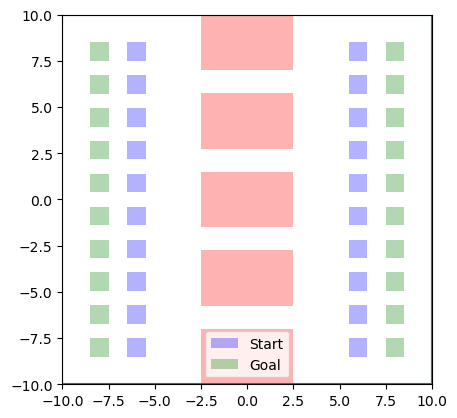

In [ ]:
draw_env(env)

In [27]:
# from panav.TrafficAwarePlanning import traffic_aware_HG_plan
# def PIBT_plan(HG,vmax,bloating_r,TIMEOUT,consider_entry=False):
#     paths = traffic_aware_HG_plan(HG)
#     ref_plan = [np.array([HG.node_loc(u) for u in path]).T for path in paths]
#     plans = ref_plan

#     # The execution time of ORCA velocity.
#     # Should be much shorter than the safe interval tau.
#     tau = 1.0 # The safe time interval. Can be generously long.
#     exec_tau = 0.5 * tau # Leaving a slight horizon margin helps avoid numerical inaccuracy in CVXPY optimization results.

#     start_locs = HG.env.starts
#     goal_locs = HG.env.goals
#     N = len(start_locs)

#     agents = np.arange(N)


#     v_prefs = [np.zeros(start_locs[0].shape) for a in agents]

#     protocol = 0

#     orcas = [Ordered_Agent(protocol,tau,bloating_r,vmax,p,init_v = None,id = id) 
#             for id,p in enumerate(start_locs)]

#     # We will assume agent i is ranked i among the agents when dealing with conflicts.
#     curr_wp_index = [1 for a in agents]

#     entry_r = 4 * bloating_r
#     occupant = [None for s in HG.nodes]

#     def towards(cur_loc, wp):
#         to_wp = wp-cur_loc
#         return to_wp/tau if tau * vmax > np.linalg.norm(to_wp) else vmax *  to_wp/(np.linalg.norm(to_wp)+1e-5)

#     def calc_pref(agent):
        
#         target_wp = plans[agent][:,curr_wp_index[agent]]
#         prev_node = paths[agent][curr_wp_index[agent]-1]
#         next_node = paths[agent][curr_wp_index[agent]]

#         agent_loc = orcas[agent].p

#         def is_entry(prev_node,next_node):
#             return HG.nodes[prev_node]['type']!='tunnel' and HG.nodes[next_node]['type']=='tunnel'


#         if not consider_entry or not is_entry(prev_node,next_node):
#             # Not a tunnel entry
#             v_prefs[agent] = towards(agent_loc,target_wp) 
#         else:
#             # Tunnel entry
#             if np.linalg.norm(agent_loc-target_wp)<=entry_r:
#                 if occupant[next_node] is not None and occupant[next_node]!=agent:
#                     # Defer to the current occupant
#                     temp_loc = agent_loc # Go to the waiting position.
#                     v_prefs[agent] = towards(agent_loc,temp_loc)
#                 else:
#                     # Claim the target node
#                     occupant[next_node] = agent 
#                     v_prefs[agent] = towards(agent_loc,target_wp) 
#             else:
#                 v_prefs[agent] = towards(agent_loc,target_wp) 

        
#         # See if the agent has reached the current waypoint.
#         if np.linalg.norm(agent_loc-target_wp)<= bloating_r:  
#             if consider_entry and is_entry(prev_node,next_node):
#                 # Release the target node
#                 if occupant[next_node] == agent:
#                     occupant[next_node] = None

#             curr_wp_index[agent] += 1 
#             curr_wp_index[agent] = min([curr_wp_index[agent],
#                                         plans[agent].shape[1]-1])
            
            

#     def PIBT(a):

#         P = []
#         C = []

#         for nb in agents:
#             # Find all agents in the that could collide with a in the next tau seconds.
#             if nb!=a and np.linalg.norm(orcas[nb].p-orcas[a].p)<orcas[nb].bloating_r+orcas[a].bloating_r\
#                                                     + vmax * tau:
#                 if np.linalg.norm(orcas[nb].p-orcas[a].p)<orcas[nb].bloating_r+orcas[a].bloating_r:
#                     print("Soft Collision. Agents ",a,nb,"Dist",np.linalg.norm(orcas[nb].p-orcas[a].p))
#                 if orcas[nb].v is None:
#                     C.append(nb)
#                 else:
#                     P.append(nb)
            
#         candidate_v_pref = [] 

#         for theta in np.pi * np.linspace(0,2,4)[:-1]:
#                 # Rotate v_pref clockwise by theta.
#                 v_right = np.array([[np.cos(-theta),-np.sin(-theta)],
#                                     [np.sin(-theta),np.cos(-theta)]]).dot(v_prefs[a])
#                 candidate_v_pref.append(v_right)

#         candidate_v_pref.append(np.array([0,0])) # Always have zero velocity as a default 
        
#         for i,v_pref in enumerate(candidate_v_pref):
#             orcas[a].update_v(v_pref,env.obstacles,[orcas[b] for b in P]) 
#             if orcas[a].v is None:
#                 return False
            
#             children_valid = True
#             for c in C:
#                 if orcas[c].v is None:
#                     children_valid = PIBT(c)
#                     if not children_valid:
#                         break
            
#             if children_valid:
#                 return True

#         orcas[a].v = None
#         return False
    
    
#     pos = [[] for _ in range(N)]
#     times = [[] for _ in range(N)]

#     curr_t = 0

#     for _ in range(400):
#         # print("################# Time step {} ################".format(_))
#         for a in agents:
#             pos[a].append(np.array(orcas[a].p))
#             times[a].append(curr_t)

#         curr_t += exec_tau
        
#         for a in agents:
#             # Compute the preferred velocity.
#             calc_pref(a)         

#             prev_wp = curr_wp_index[a]-1
#             cur_wp = curr_wp_index[a]
#             u,v = paths[a][prev_wp:cur_wp+1]
#             cur_edge_type = HG.edges[u,v]['type']
#             if cur_edge_type == 'soft':
#                 orcas[a].vmax = 1.0 * vmax # On open space, move slower to avoid congestion at tunnel endpoints
#             else:
#                 orcas[a].vmax = vmax # In tunnel, move quickly 
        
        
#         for a in agents: 
#             if orcas[a].v is None:
#                 valid = PIBT(a)
#         # We assume agent a is ranked a among the agents when dealing with conflicts.

#         # Execute the safe velocity.
#         all_reached = True
        
#         for a in agents:
#             dist2goal = np.linalg.norm(orcas[a].p - goal_locs[a])
    
#             if dist2goal>=0.5*bloating_r:
#                 orcas[a].p += orcas[a].v*exec_tau
#                 all_reached = False
#                 # Reset all agent's v to be None
#                 orcas[a].v = None
#             else:
#                 orcas[a].goal_reached = True
#                 orcas[a].v = orcas[a].v_opt = np.array([0,0])

#         if all_reached:
#             break
#     return [(ts,xs) for ts,xs in zip(times,pos)]

In [34]:
from panav.PIBT import PIBT_plan
plans = PIBT_plan(HG,vmax,bloating_r,TIMEOUT=1,consider_entry=True)

TIMEOUT
TIMEOUT
TIMEOUT
TIMEOUT
TIMEOUT
TIMEOUT
TIMEOUT
TIMEOUT
TIMEOUT
TIMEOUT
TIMEOUT
PIBT failed


In [32]:
from panav.viz import animation
from IPython.display import HTML, display

exec_tau = 1.0

dt = exec_tau * 0.25
agents = range(len(plans))
pos_to_ani = [np.array(plans[a][1]).T for a in agents]
anim = animation(env, pos_to_ani, bloating_r, dt = dt)
display(HTML(anim.to_jshtml()))
plt.close() 